# Second Homework - SHAP

This homework bases on the models used in the first homework in the prediction of students' grades on the Alcohol Effects on Study dataset. 


#Dependencies

In [ ]:
!pip install dalex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.6 MB/s 
  Created wheel for dalex: filename=dalex-1.5.0-py3-none-any.whl size=1043321 sha256=da6b674d7a0bcb93d5a6d49d52b52778edfb2130506b6177f80fbf306c5d76a2
  Stored in directory: /root/.cache/pip/wheels/76/31/8c/c78df586df31b3f3e0c4ecc759ee73e175545cff5548201996
Successfully built dalex


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.7 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import shap
import dalex as dx

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import random

#Downloading Dataset
Firstly, in order to download Alcohol Effects on Study dataset, we mount google drive and upload kaggle API.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files

Mounted at /content/gdrive


In [ ]:
files.upload() #this will prompt you to upload the kaggle.jso

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paulinakaczyska","key":"a590f81fa200cd408d5cb174df96882a"}'}

In [ ]:
#make sure kaggle.json file is present
!ls -lha kaggle.json

#Install kaggle API client
!pip install -q kaggle

#kaggle API client expects the file to be in ~/.kaggle

#so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#seting permissions
!chmod 600 /root/.kaggle/kaggle.json

#check your directory before downloading the datasets
!pwd

#downloading
!kaggle datasets download -d whenamancodes/alcohol-effects-on-study

#unzipping
!unzip alcohol-effects-on-study.zip

-rw-r--r-- 1 root root 71 Oct 24 16:20 kaggle.json
/content
  0% 0.00/18.1k [00:00<?, ?B/s]
100% 18.1k/18.1k [00:00<00:00, 16.6MB/s]
Archive:  alcohol-effects-on-study.zip
  inflating: Maths.csv               
  inflating: Portuguese.csv          


# Data Preprocessing

In [ ]:
binary = ['school', 'sex', 'address', 'famsize', 'Pstatus','schoolsup', 'famsup', 'paid', 'activities', 'nursery','higher', 'internet', 'romantic']
categorical_nb = ['Mjob', 'Fjob', 'reason', 'guardian']
numerical = ['Medu', 'Fedu','traveltime', 'studytime','failures','famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

The categorical data are one-hot encoded. Data is divided to input and output.

In [ ]:
math = pd.read_csv("Maths.csv", encoding = "UTF-8")
port = pd.read_csv("Portuguese.csv", encoding = "UTF-8")

math_i_c = pd.get_dummies(math[binary+categorical_nb],drop_first = True)
port_i_c = pd.get_dummies(port[binary+categorical_nb],drop_first = True)

math_o = math.iloc[:,-1]
port_o = port.iloc[:,-1]


In [ ]:
math

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


Data is combined into input X and output Y arrays.

In [ ]:

math_array = pd.concat([math_i_c,math[numerical]],axis=1)
port_array = pd.concat([port_i_c,port[numerical]],axis=1)
X = pd.concat((math_array,port_array),axis = 0).reset_index().drop(['index'],axis=1)
Y = pd.concat((math_o,port_o),axis = 0).reset_index().drop(['index'],axis=1)


Division for test and train dataset is made using train_test_split from sklearn library.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=100, train_size=len(X)-100)

In [ ]:
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

#1. Training a tree-based ensemble model (Random Forest Regressor):

Firstly, I train Random Forest Regression using function from sklearn package. This method is a tree ensemble method. 

In [ ]:
model_rfr = RandomForestRegressor(n_estimators = 300, max_depth=4, random_state=0)
model_rfr.fit(X_train, y_train)

y_pred = model_rfr.predict(X_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


I select two observations from the dataset and calculate the model's prediction.


In [ ]:
sample = random.sample(list(X.index),2)

X_sample = X.iloc[sample]
Y_sample = Y.iloc[sample]

Y_pred_sample = model_rfr.predict(X_sample)

I calculate the decomposition of predictions for the two students sampled above, using SHAP from dalex and shap.

In [ ]:
# explain the model with SHAP
explainer_rfr_shap = shap.explainers.Tree(model_rfr, data=X_train)
shap_values_rfr = explainer_rfr_shap(X_sample)

That is how shap_values for the two students look like:

In [ ]:
shap_values_rfr

.values =
array([[ 8.29053401e-03, -4.01134619e-03,  7.14473805e-03,
         5.01156472e-02,  4.32619967e-03,  1.20353404e-02,
         6.63138115e-03,  3.00098952e-02, -1.71745000e-03,
        -9.42108135e-03, -6.52380208e-01,  4.16446571e-03,
         5.20154531e-03, -5.27507563e-03,  1.24929969e-02,
        -5.85051873e-03,  1.30712409e-02, -1.58721341e-03,
         1.62302615e-03,  1.46401044e-02, -8.53390584e-02,
         6.33715763e-03,  2.03997282e-03, -6.94486718e-04,
         1.68695924e-02,  6.27228624e-02, -2.88498815e-02,
         1.89950510e-02, -1.47451277e-02, -7.42885414e-02,
        -2.03657523e+00, -6.31118219e-02, -3.96556327e-02,
         1.75405440e-02, -1.03288244e-01, -6.48303935e-02,
         1.94516681e-02,  1.25827445e+00],
       [ 1.78704207e-02, -4.61656886e-03,  6.90947736e-03,
         3.75840356e-02, -1.34533770e-03, -5.57905049e-01,
         1.74277538e-03,  9.47705663e-02, -1.51508134e-03,
         3.30730906e-03,  1.19538253e-01,  1.13984166e-02,
   

This are the waterfall plots for both students, explaining contribution of the features to the final prediction:

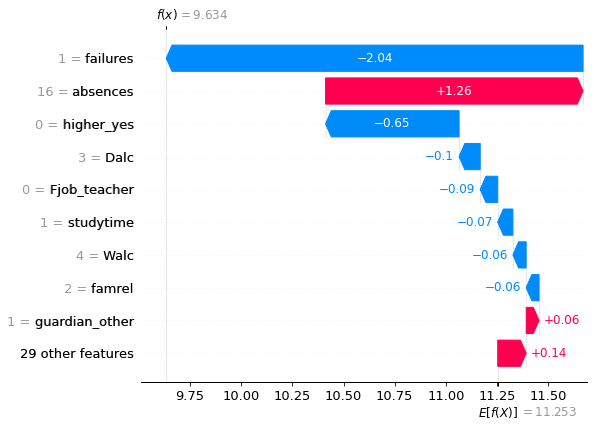

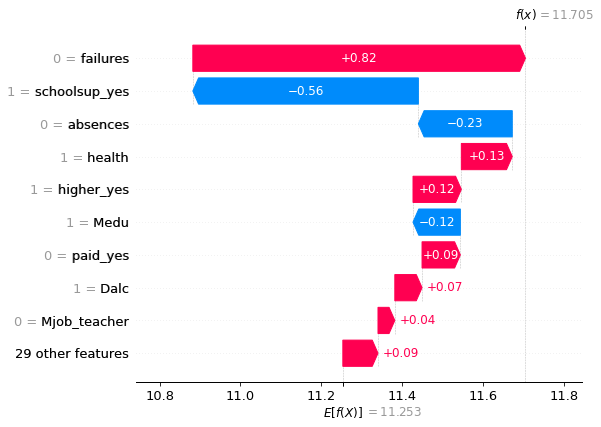

In [ ]:
for i in range(2):
  shap.plots.waterfall(shap_values_rfr[i])

Now I do the same with Dalex.

In [ ]:
import dalex as dx
rfr_default = lambda m, d: m.predict(d)#[:, 1]

explainer = dx.Explainer(model_rfr, X_train, y_train, predict_function=rfr_default, label="GBM")

Preparation of a new explainer is initiated

  -> data              : 944 rows 38 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 944 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : GBM
  -> predict function  : <function <lambda> at 0x7f956255a200> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


  -> predicted values  : min = 1.85, mean = 11.4, max = 15.6
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -13.1, mean = 0.011, max = 7.17
  -> model_info        : package sklearn

A new explainer has been created!


Here are waterfall plots made with dalex:

In [ ]:
shap_attributions = [explainer.predict_parts(X.iloc[i], type="shap", label=f'student {i}') for i in sample]

shap_attributions[0].plot(shap_attributions[1::])

It is interesting that the explanations for both students differ slightly in shap and dalex. For example Shapley value for failure is -2.04 in shap and -1.712 in dalex. However, top features seem to remain the same and the difference seems to be quantitative. 

# Two observations with different variables of the highest importance and the same feature contributing differently

In [ ]:
shap_values_rfr_all = explainer_rfr_shap(X)

 98%|===================| 1027/1044 [00:13<00:00]       

In [ ]:
shap_values_rfr_all.values.argmax(axis=1)

array([20, 30, 37, ..., 30, 30, 30])

Without looking further, the two first students in the dataframe seem to meet the condition. I check it on the visualisation:

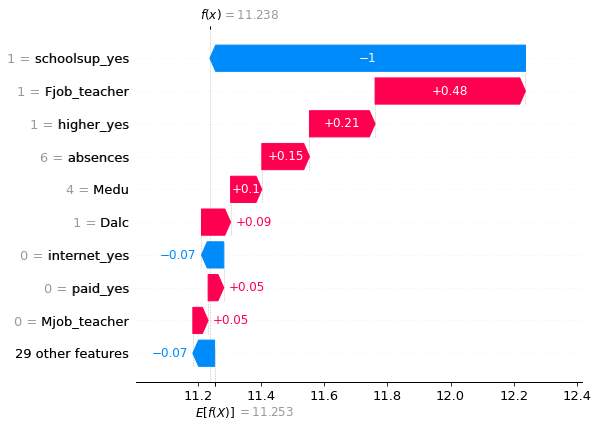

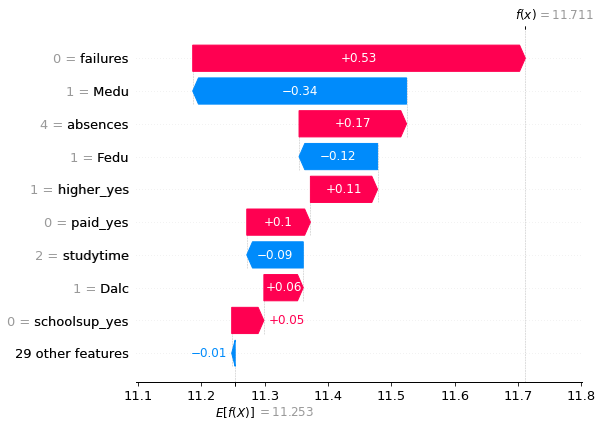

In [ ]:
for i in range(2):
  shap.plots.waterfall(shap_values_rfr_all[i])

Indeed, for the first student the most important features is school support and father beeing a teacher, and for the second student it is number of failures and mothers' education.

It is very convenient that this two students can be an example for the prediction, where the same feature is contributing positively to one prediction and negatively to the other. For the first student mother's education (Medu) is contributing slightly positively to the final score and for the second it is contributing negatively.

#Training linear model

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
explainer_lr_shap = shap.explainers.Linear(model_lr,X)
shap_values_lr = explainer_lr_shap(X)

I check first students and for the 5th one the explanation differs quite much:

The SHAP decomposition of prediction for the 3rd student in Random Forest Regression


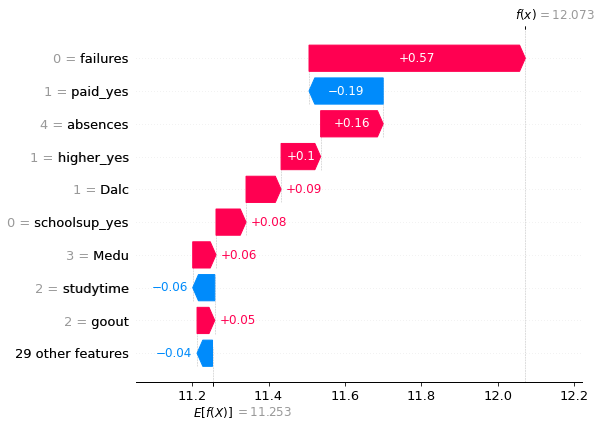

The SHAP decomposition of prediction for the 3rd student in Linear Regression


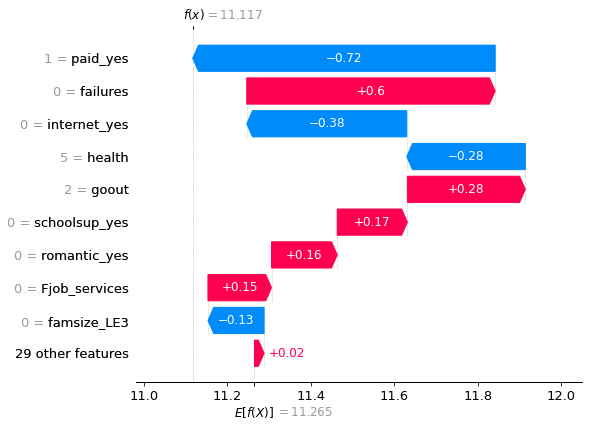

In [ ]:
print('The SHAP decomposition of prediction for the 5th student in Random Forest Regression')
shap.plots.waterfall(shap_values_rfr_all[4])
print('The SHAP decomposition of prediction for the 5th student in Linear Regression')
shap.plots.waterfall(shap_values_lr[4])

FOr the linear regression the most important feature is taking extra classes, while for the Random Forest it is the number of failures. In the linear regression other features matter, but for the random forest their contribution is much smaller than the first one's. It is intuitive difference for the model basing on decision trees (the first choice is much more important). 

#The computation of Shapley Values

v() = 0\
v(A) = 20\
v(B) = 20\
v(C) = 60\
v(A,B) = 60\
v(A,C) = 70\
v(B,C) = 70\
v(A,B,C) = 100\
$$\frac{1}{3!}\sum_{S\in\{B,C,\{B,C\},\{\}\}}S!(n-|S|-1)!(v(S\bigcup\{i\}-v(S)) = \frac{1}{6}(v(A,B)-v(B)+v(A,C)-v(C)+2*(v(A,B,C)-v(B,C))+2*(v(A)-v())) = 
\frac{1}{6}(40+10+60+40)=25$$
The Shapley value of A with this value function is 25